In [1]:
import numpy
import pandas

import conntility

from matplotlib import pyplot as plt
from distribution import sis, cut_zeros_and_shift
from fitting import optimize_touch_model


fn_rat = "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Rat_623um_squared_struc_conmat_filtered_compressed.h5"
fn_human = "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Human_960um_squared_struc_conmat_filtered_compressed.h5"

loaded = "human"  # Set to human to analyze that instead

if loaded == "rat":
    M_h = conntility.ConnectivityMatrix.from_h5(fn_rat)
elif loaded == "human":
    M_h = conntility.ConnectivityMatrix.from_h5(fn_human)

M_h.vertices

,index,population,node_ids,etype,layer,morphology,mtype,synapse_class,x,y,z,ss_flat_x,depth,ss_flat_y
0,0,hncx_neurons,0,PYR_L23,L2,685814252_-_Scale_x1.000_y1.050_z1.000,L23_PTPC,EXC,779.973032,2255.463864,1538.881747,1267.973032,352.536136,1562.881747
1,1,hncx_neurons,1,PYR_L23,L2,665713811_-_Scale_x1.000_y1.025_z1.000,L23_PTPC,EXC,1076.796974,2245.365871,865.911045,1564.796974,362.634129,889.911045
2,6,hncx_neurons,6,PYR_L23,L2,758319694,L23_PTPC,EXC,601.192085,2085.837710,1382.693416,1089.192085,522.162290,1406.693416
3,11,hncx_neurons,11,PYR_L23,L2,602165685,L23_PTPC,EXC,757.470091,2226.168333,984.828784,1245.470091,381.831667,1008.828784
4,12,hncx_neurons,12,PYR_L23,L2,596898838_-_Scale_x1.000_y0.975_z1.000,L23_PTPC,EXC,821.995965,2247.111072,1240.299471,1309.995965,360.888928,1264.299471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20017,107471,hncx_neurons,107471,PYR_L23,L3b,1067_H38_01_160113_cell2_-_Scale_x1.000_y0.950...,L23_STPC,EXC,542.088822,1522.737173,1432.527308,1030.088822,1085.262827,1456.527308
20018,107480,hncx_neurons,107480,PYR_L23,L3b,685815936_-_Scale_x1.000_y0.975_z1.000,L23_STPC,EXC,832.459351,1668.380689,798.964852,1320.459351,939.619311,822.964852
20019,107481,hncx_neurons,107481,PYR_L23,L3b,685815936_-_Scale_x1.000_y1.050_z1.000,L23_STPC,EXC,370.294247,1571.087143,1452.238771,858.294247,1036.912857,1476.238771
20020,107487,hncx_neurons,107487,PYR_L23,L3b,1081_H42-10,L23_STPC,EXC,832.873951,1644.785453,870.675550,1320.873951,963.214547,894.675550


In [2]:
# Some meta-parameters

max_touch_count = 100
n_dist_bins = 9
num_edges_last_bin = 5000

In [3]:
# Add distance and distance bin information to the edges.
# The table of edges must contains columns "bin" (distance bin index) and "count" (number of touches). 

sum_deltas = numpy.zeros(len(M_h.edges))

for axis in ["x", "y", "z"]:
    prop = M_h.edge_associated_vertex_properties(axis)
    delta = prop["row"].values - prop["col"].values
    sum_deltas += (delta ** 2)

M_h.add_edge_property("distance", numpy.sqrt(sum_deltas))

# Linear distance bins (for now)
tgt_percentile = 100 * (1.0 - 5000 / len(M_h.edges)) # This way, the last distance bin will contain the specified number of edges.
max_dist = numpy.percentile(M_h.edges["distance"], tgt_percentile)

dbins = numpy.linspace(1E-9, max_dist, n_dist_bins)
bin_centers = dbins + 0.5 * numpy.mean(numpy.diff(dbins))
M_h.add_edge_property("bin", numpy.digitize(M_h.edges["distance"], bins=dbins) - 1)

## First attempt: Fit every parameter

This will not be perfect. Later we will build a better one.

In [4]:
# Optimize the model

opt_params, opt_model = optimize_touch_model(M_h.edges, bin_centers, max_num_touches=max_touch_count)

Number of args to optimize: 6
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


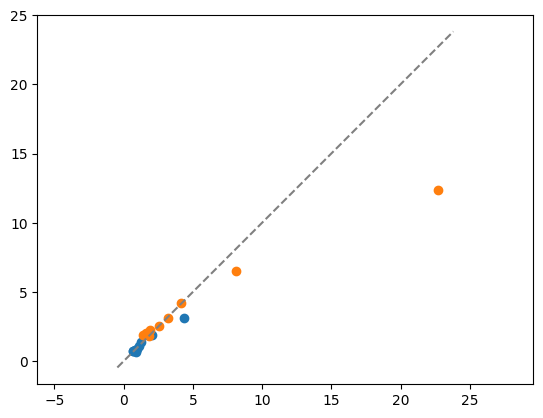

In [5]:
# Validation 1: Mean and variance of extra touches (beyond the first) in each distance bin

# Data
mean_extra_edges = M_h.edges.groupby("bin")["count"].mean().values - 1 # -1 because we count touches beyond the first.
var_extra_edges = M_h.edges.groupby("bin")["count"].var().values # variance is unaffected by subtracting a constant

# Model
# cut_zeros_and_shift converts the model to a model of extra touches.
mdl, _ = cut_zeros_and_shift(sis(opt_model["i"], opt_model["f"], opt_model["p"], max_touch_count))
mn, var = mdl.stats()

plt.plot(mean_extra_edges, mn, 'o')
plt.plot(var_extra_edges, var, 'o')
plt.axis("equal")
plt.plot(plt.gca().get_xlim(), plt.gca().get_xlim(), ls="--", color="grey")

(-1.0, 50.0)

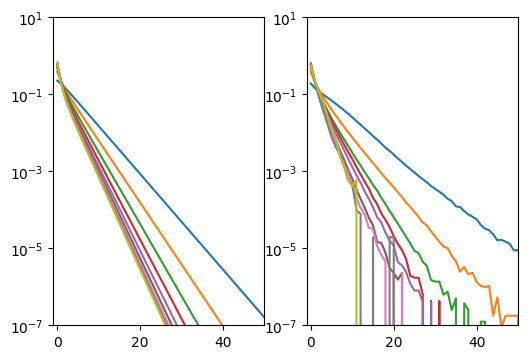

In [6]:
# Validation 2: Touch count distributions

extra_touches = numpy.arange(0, max_touch_count + 1)

prob_data = M_h.edges.groupby("bin")["count"].apply(lambda x: 
                                                    pandas.Series(numpy.histogram(x - 1, bins=extra_touches,
                                                                                  density=True)[0],
                                                                  index=pandas.Index(extra_touches[:-1], name="touches")))

prob_model = pandas.concat([pandas.Series(mdl.pmf(_x), index=pandas.Index(range(n_dist_bins), name="bin"))
                            for _x in extra_touches[:-1]],
                          keys=extra_touches[:-1], names=["touches"])
                                                  

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(1, 2, 1); ax2 = fig.add_subplot(1, 2, 2)

_ = ax1.plot(prob_model.unstack("bin"))
_ = ax2.plot(prob_data.unstack("bin"))

ax1.set_yscale('log')
ax1.set_ylim((1E-7, 10))
ax1.set_xlim((-1, 50))

ax2.set_yscale('log')
ax2.set_ylim((1E-7, 10))
ax2.set_xlim((-1, 50))

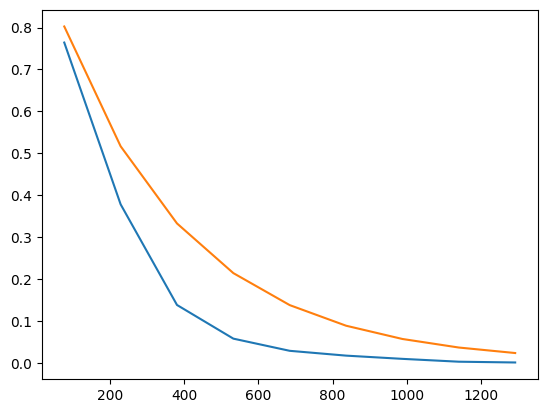

In [7]:
# Validation 3: Distance-dependent connection probability.

from scipy.spatial import distance

# Data.
D = distance.squareform(distance.pdist(M_h.vertices[["x", "y", "z"]]))
D = numpy.digitize(D, bins=dbins) - 1
pair_count = numpy.histogram(D, bins=range(n_dist_bins + 1))[0]
edge_count = M_h.edges["bin"].value_counts().sort_index()
con_prob_data = edge_count.values / pair_count

# Model.
con_prob_mdl = opt_params["A_i"] * numpy.exp(-bin_centers * opt_params["B_i"])

# Plot to compare
plt.plot(bin_centers, con_prob_data)
plt.plot(bin_centers, con_prob_mdl)

## Second attempt: Fit connection probability separately

Results were sort of OK, but can be improved!

We try to improve the fit by first independent building an exponential model of connection probability (i.e. probability to have at least one touch). This yields the values of parameters A_i and B_i. Then we separately optimize the remaining parameters.

In [8]:
from connalysis.modelling import conn_prob_2nd_order_model


p_model = conn_prob_2nd_order_model(M_h.matrix.tocsc().astype(bool), M_h.vertices)

 2024-04-02 11:43:30,461: Running order-2 model building {'model_dir': None, 'data_dir': None, 'plot_dir': None, 'do_plot': False, 'part_idx': None, 'sample_seed': None}...
 2024-04-02 11:43:35,000: Extracting 1-dimensional (17) connection probabilities...
100% |########################################################################|
 2024-04-02 11:45:09,522: MODEL FIT: f(x) = 1.141962 * exp(-0.004969 * x)


(0.0, 1.0)

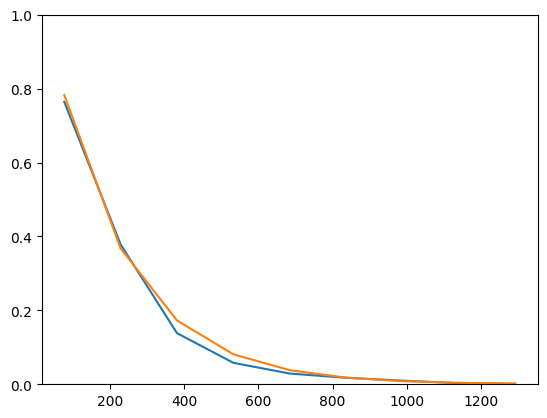

In [9]:
A_i = p_model["exp_model_scale"].iloc[0]
B_i = p_model["exp_model_exponent"].iloc[0]

con_prob_exp_model = A_i * numpy.exp(-bin_centers * B_i)

plt.plot(bin_centers, con_prob_data)
plt.plot(bin_centers, con_prob_exp_model)
plt.gca().set_ylim([0, 1])

In [10]:
# Optimize the model

opt_params, opt_model = optimize_touch_model(M_h.edges, bin_centers, max_num_touches=max_touch_count,
                                            A_i=A_i, B_i=B_i)
assert opt_params["A_i"] == A_i
assert opt_params["B_i"] == B_i

Number of args to optimize: 4
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


In [11]:
print(opt_params)

{'A_i': 1.1419623634593399, 'B_i': 0.004968682579856109, 'A_f': 0.3170040545553423, 'B_f': 0.0022466326081607337, 'C_f': 0.5445884738956015, 'p': 0.5758916509806618}


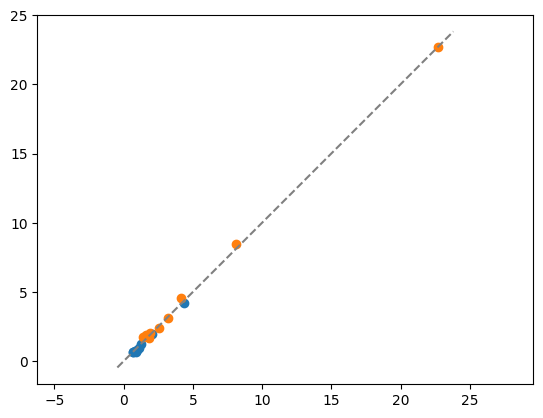

In [12]:
# Validation 1: Mean and variance of extra touches (beyond the first) in each distance bin

# Data
mean_extra_edges = M_h.edges.groupby("bin")["count"].mean().values - 1 # -1 because we count touches beyond the first.
var_extra_edges = M_h.edges.groupby("bin")["count"].var().values # variance is unaffected by subtracting a constant

# Model
# cut_zeros_and_shift converts the model to a model of extra touches.
mdl, _ = cut_zeros_and_shift(sis(opt_model["i"], opt_model["f"], opt_model["p"], max_touch_count))
mn, var = mdl.stats()

plt.plot(mean_extra_edges, mn, 'o')
plt.plot(var_extra_edges, var, 'o')
plt.axis("equal")
plt.plot(plt.gca().get_xlim(), plt.gca().get_xlim(), ls="--", color="grey")

(-1.0, 50.0)

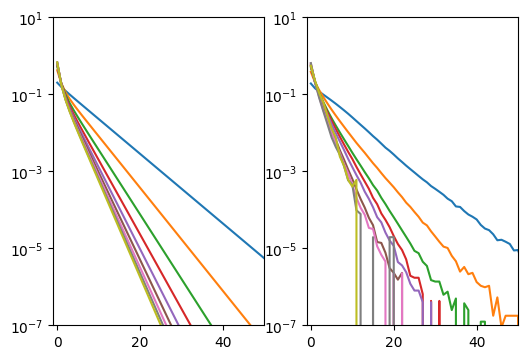

In [13]:
# Validation 2: Touch count distributions

extra_touches = numpy.arange(0, max_touch_count + 1)

prob_data = M_h.edges.groupby("bin")["count"].apply(lambda x: 
                                                    pandas.Series(numpy.histogram(x - 1, bins=extra_touches,
                                                                                  density=True)[0],
                                                                  index=pandas.Index(extra_touches[:-1], name="touches")))

prob_model = pandas.concat([pandas.Series(mdl.pmf(_x), index=pandas.Index(range(n_dist_bins), name="bin"))
                            for _x in extra_touches[:-1]],
                          keys=extra_touches[:-1], names=["touches"])
                                                  

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(1, 2, 1); ax2 = fig.add_subplot(1, 2, 2)

_ = ax1.plot(prob_model.unstack("bin"))
_ = ax2.plot(prob_data.unstack("bin"))

ax1.set_yscale('log')
ax1.set_ylim((1E-7, 10))
ax1.set_xlim((-1, 50))

ax2.set_yscale('log')
ax2.set_ylim((1E-7, 10))
ax2.set_xlim((-1, 50))

Not running the third validation. We know the A_i and B_i parameters are as indicated above. It will come out exactly as the validation of that fit above.

## Randomizing the number of touches while keeping the edges.

We can now use the fitted and validated models to generate new, random connectivity matrices. Simply generate random variates for each pair, depending on the distance bin it is in.

Here, we demonstrate a slightly more complicated randomization. We keep the position of each edge, (the pre- and post-synaptic neuron) but randomize its number of touches.

In [14]:
rnd_touches = numpy.zeros(len(M_h.edges), dtype=int)

for bin_id in range(n_dist_bins):
    mask = M_h.edges["bin"] == bin_id
    mdl_extra_touches, _ = cut_zeros_and_shift(  # Convert to distribution of extra touches
                            sis(
                                opt_model["i"][bin_id],
                                opt_model["f"][bin_id],
                                opt_model["p"],
                                max_touch_count))
    rnd_touches[mask] = mdl_extra_touches.rvs(size=mask.sum()) + 1  # plus one to add the first touch back to it

assert not numpy.any(rnd_touches == 0)
M_h.add_edge_property("rnd_count", rnd_touches)

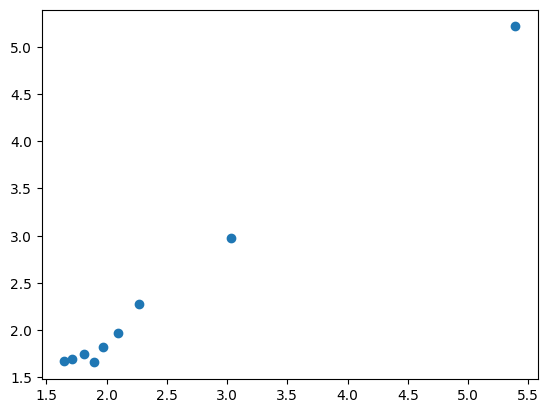

In [15]:
# Validation 1: Mean in distance bins matches

mn_data = M_h.edges.groupby("bin")["count"].mean()
mn_model = M_h.edges.groupby("bin")["rnd_count"].mean()
plt.plot(mn_data, mn_model, 'o')

/nvme/reimann/2107386/ipykernel_119198/1382726085.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(numpy.log10(H2d))


(-0.5, 98.5)

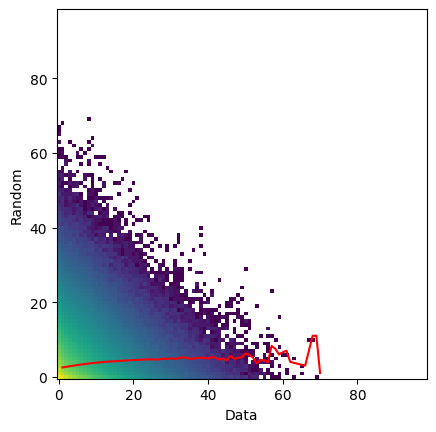

In [16]:
# Sanity check:
# There should be some correlation between the number of touches in the data and the randomly generated value, 
# but not too much. 
count_bins = numpy.arange(1, max_touch_count + 1)
H2d = numpy.histogram2d(M_h.edges["rnd_count"], M_h.edges["count"], bins=(count_bins, count_bins))[0]
mn_grouped = M_h.edges.groupby("count")["rnd_count"].mean()

plt.imshow(numpy.log10(H2d))
plt.plot(mn_grouped, color="red")

plt.gca().set_xlabel("Data")
plt.gca().set_ylabel("Random")
plt.gca().set_ylim(plt.gca().get_ylim()[::-1])